In [24]:
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds
from plot_utils import visualize_category_sounds,create_histogram_subplot
from feature_utils import compute_features_for_wave_list, compute_combined_features_for_wave_list, save_features_to_npz, save_multiple_features_to_npz
import numpy as np
from sklearn.model_selection import train_test_split

In [25]:
# 1) Specify paths
csv_file_path = "ESC-50-master/meta/esc50.csv"
audio_files_path = "ESC-50-master/audio/"

# 2) Load metadata
df = load_metadata(csv_file_path)

print(df)

# 3) Define categories
categories = {
    'Animals': ['dog', 'cat'],
    'Natural soundscapes & water sounds': ['rain', 'sea_waves'],
    'Human sounds': ['coughing', 'footsteps'],
    'Interior/domestic sounds': ['keyboard_typing', 'vacuum_cleaner'],
    'Exterior/urban noises': ['airplane', 'car_horn']
}

# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# 5) Load wave data
# wave_list_data = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path)

# 6) Visualize
# visualize_category_sounds(wave_list_data)

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]


In [26]:
len(wave_list_data)

400

In [27]:
for i in range(3):
    print(f"Sample {i+1}:")
    print("  Category:", wave_list_data[i][0])
    print("  Filename:", wave_list_data[i][1])
    print("  Sample Rate:", wave_list_data[i][2])
    print("  Sound Data Shape:", wave_list_data[i][3].shape)
    print("-" * 30)

Sample 1:
  Category: Animals
  Filename: 1-100032-A-0.wav
  Sample Rate: 44100
  Sound Data Shape: (220500,)
------------------------------
Sample 2:
  Category: Animals
  Filename: 1-110389-A-0.wav
  Sample Rate: 44100
  Sound Data Shape: (220500,)
------------------------------
Sample 3:
  Category: Animals
  Filename: 1-30226-A-0.wav
  Sample Rate: 44100
  Sound Data Shape: (220500,)
------------------------------


In [28]:
# 7) Extract features
keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)
# 8) Save features
save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_test.npz")

Features saved to features/extracted_features_test.npz


In [29]:
loaded_data_1 = np.load("features/extracted_features_test.npz")

In [30]:
print("Keys shape:", loaded_data_1['keys'].shape)
print("Features shape:", loaded_data_1['features'].shape)

Keys shape: (400,)
Features shape: (400, 109)


In [31]:
keys_list, mfcc_list, hist_list, spectral_list = compute_features_for_wave_list(wave_list_data)

save_multiple_features_to_npz(keys_list, mfcc_list, hist_list, spectral_list, out_file="features/extracted_features_multiple_test.npz")


Multiple features saved to features/extracted_features_multiple_test.npz


In [32]:
loaded_data = np.load("features/extracted_features_multiple_test.npz")
print("Stored arrays:", loaded_data.files)

print("Keys shape:", loaded_data['keys'].shape)
print("MFCC shape:", loaded_data['mfcc'].shape)
print("Histogram shape:", loaded_data['hist'].shape)
print("Spectral shape:", loaded_data['spectral'].shape)

print("First MFCC feature vector:", loaded_data['mfcc'][0])
print("First histogram feature vector:", loaded_data['hist'][0])
print("First spectral feature vector:", loaded_data['spectral'][0])

Stored arrays: ['keys', 'mfcc', 'hist', 'spectral']
Keys shape: (400,)
MFCC shape: (400, 26)
Histogram shape: (400, 80)
Spectral shape: (400, 3)
First MFCC feature vector: [-5.8173993e+02  8.2071218e+00 -6.6588025e+00 -4.2909064e+00
 -3.0344779e+00  2.5927922e-01 -1.9639465e+00 -2.7157682e-01
  5.1828414e-01  3.4188423e-01  9.0610188e-01 -9.5245531e-03
 -1.9054951e-01  0.0000000e+00 -1.7701611e-08  0.0000000e+00
 -8.8508054e-09  0.0000000e+00  0.0000000e+00  4.4254027e-09
  6.9146922e-10 -2.2127014e-09  5.5317534e-10  0.0000000e+00
 -1.1063507e-09  0.0000000e+00]
First histogram feature vector: [9.90483614e-01 5.11165893e-03 2.35643852e-03 7.97563805e-04
 7.25058005e-04 1.99390951e-04 1.81264501e-04 9.06322506e-05
 3.62529002e-05 1.81264501e-05 9.92241879e-01 4.27784223e-03
 1.45011601e-03 8.15690255e-04 3.44402552e-04 3.08149652e-04
 2.35643852e-04 1.45011601e-04 1.63138051e-04 1.81264501e-05
 9.93855133e-01 4.38660093e-03 1.12383991e-03 3.26276102e-04
 1.45011601e-04 5.43793503e-05 3

In [33]:
unique_keys = set(keys_list)
print("Unique class labels:", unique_keys)


Unique class labels: {0, 32, 36, 5, 10, 11, 43, 47, 24, 25}


In [34]:
# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']

In [35]:
combined_features = np.hstack([mfcc_features, hist_features, spectral_features])

In [36]:
selected_features = mfcc_features

In [37]:
selected_features2= np.hstack([mfcc_features,spectral_features])

In [38]:
X = selected_features
y = keys_list

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split into training and testing sets

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (320, 26)
Test set size: (80, 26)


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           5       0.00      0.00      0.00        12
          10       0.83      0.56      0.67         9
          11       0.60      0.75      0.67         8
          24       0.10      0.40      0.16         5
          25       0.33      0.71      0.45         7
          32       0.57      0.50      0.53         8
          36       0.33      0.67      0.44         3
          43       0.00      0.00      0.00        12
          47       0.67      0.67      0.67         6

    accuracy                           0.44        80
   macro avg       0.42      0.50      0.43        80
weighted avg       0.41      0.44      0.40        80



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


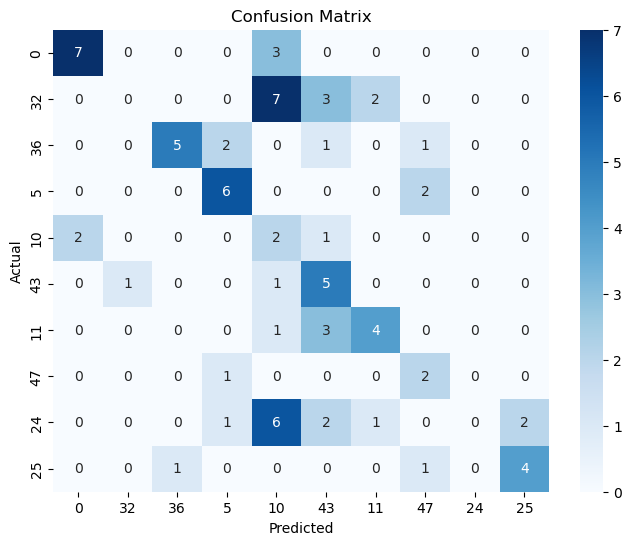

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the SVM classifier
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           5       0.60      0.50      0.55        12
          10       0.62      0.56      0.59         9
          11       1.00      0.75      0.86         8
          24       0.22      0.40      0.29         5
          25       0.25      0.29      0.27         7
          32       0.64      0.88      0.74         8
          36       0.43      1.00      0.60         3
          43       0.50      0.17      0.25        12
          47       0.57      0.67      0.62         6

    accuracy                           0.56        80
   macro avg       0.56      0.60      0.55        80
weighted avg       0.59      0.56      0.55        80



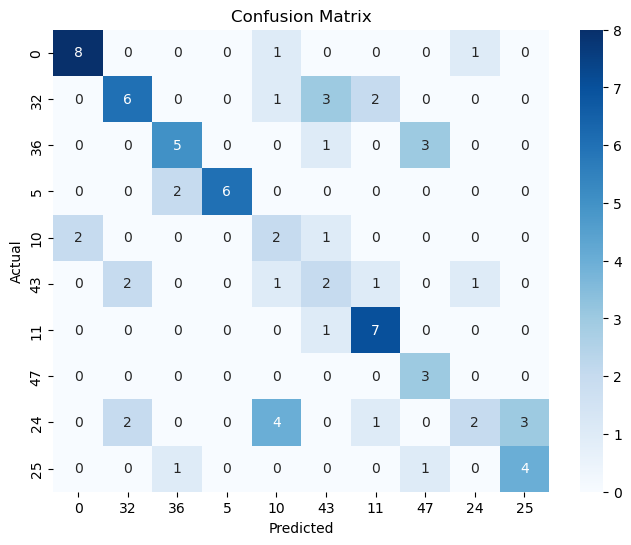

In [41]:
svm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
from sklearn.decomposition import PCA

# Reduce features to 4 dimensions using PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [8.5233170e-01 8.6355478e-02 2.3193656e-02 1.5195207e-02 9.9598905e-03
 3.8088369e-03 3.4105799e-03 2.1263389e-03 1.0980036e-03 7.8929716e-04]
Reduced feature shape: (320, 10)


In [43]:
vm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_pca)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           5       0.67      0.67      0.67        12
          10       0.67      0.67      0.67         9
          11       0.75      0.75      0.75         8
          24       0.30      0.60      0.40         5
          25       0.60      0.43      0.50         7
          32       0.70      0.88      0.78         8
          36       0.40      0.67      0.50         3
          43       0.75      0.25      0.38        12
          47       0.57      0.67      0.62         6

    accuracy                           0.61        80
   macro avg       0.61      0.63      0.60        80
weighted avg       0.65      0.61      0.61        80



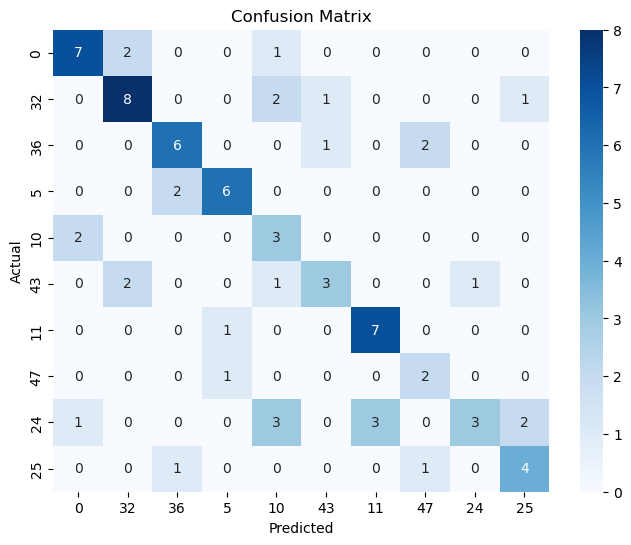

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()